In [3]:
import pandas as pd
import numpy as np
import QuantLib as ql
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from joblib import Parallel, delayed
from tqdm import tqdm
import json

## Data

In [2]:
data = pd.read_parquet('clean_data2023.pq')
# moneyness
data['moneyness'] = data['STRIKE']/data['UNDERLYING_LAST']
data = data[(data['C_IV']>0) & (data['P_IV']>0)]

df = data[(data['DTE']>=5)]
df = df[(df['moneyness']>=0.2) & (df['moneyness']<=5)]

df = df.dropna()

## Define Pricers

In [100]:
def feller_condition(params):
  kappa, theta, sigma, v0, rho = params
  return sigma**2 - 2*kappa*theta

# Define the Heston pricing function
# Generate the price of a European call option using the Fourier Transform Method with the Heston model
def eurocall_fourier(S0, m, T, r, q, v0, theta, kappa, sigma, rho):
  '''
  m: Moneyness
  T: Time to maturity of the option
  r: Risk-free interest rate
  q: Dividend yield of the underlying asset
  v0: Initial volatility of the Heston mode
  theta: Mean reversion speed of the Heston model
  kappa: Mean reversion level of the Heston model
  sigma: Volatility of the Heston model
  rho: Correlation between the asset price and volatility processes
  '''

  # Parameters
  K = S0 * m    # Strike price of the option
  option_type = ql.Option.Call

  # Set up the option
  today = ql.Date.todaysDate()
  # expiry_date = today + ql.Period(T, ql.Days)
  expiry_date = today + ql.Period(f"{int(T*365)}d")
  option = ql.VanillaOption(ql.PlainVanillaPayoff(option_type, K), ql.EuropeanExercise(expiry_date))

  # Set up the Heston model
  heston_process = ql.HestonProcess(
      ql.YieldTermStructureHandle(ql.FlatForward(0, ql.TARGET(), r, ql.Actual365Fixed())),
      ql.YieldTermStructureHandle(ql.FlatForward(0, ql.TARGET(), q, ql.Actual365Fixed())),
      ql.QuoteHandle(ql.SimpleQuote(S0)),
      v0, kappa, theta, sigma, rho
      )
  heston_model = ql.HestonModel(heston_process)
  
  # Calculate the option price using the Heston model with the Fourier transform
  heston_engine = ql.AnalyticHestonEngine(heston_model, 32)
  option.setPricingEngine(heston_engine)
  # print("The price of the European call option is:", option.NPV())

  return option.NPV()

# Generate the price of a European call option using PDE with the Heston model
def eurocall_pde(S0, m, T, r, q, v0, theta, kappa, sigma, rho):
  '''
  m: Moneyness
  T: Time to maturity of the option
  r: Risk-free interest rate
  q: Dividend yield of the underlying asset
  v0: Initial volatility of the Heston mode
  theta: Mean reversion speed of the Heston model
  kappa: Mean reversion level of the Heston model
  sigma: Volatility of the Heston model
  rho: Correlation between the asset price and volatility processes
  '''

  # Option Parameters
  K = S0 * m
  option_type = ql.Option.Call

  # Set up the option
  today = ql.Date.todaysDate()
  expiry_date = today + ql.Period(f"{int(T*365)}d")
  option = ql.VanillaOption(ql.PlainVanillaPayoff(option_type, K), ql.EuropeanExercise(expiry_date))

  # Set up the Heston process and model
  heston_process = ql.HestonProcess(
      ql.YieldTermStructureHandle(ql.FlatForward(0, ql.TARGET(), r, ql.Actual365Fixed())), 
      ql.YieldTermStructureHandle(ql.FlatForward(0, ql.TARGET(), q, ql.Actual365Fixed())), 
      ql.QuoteHandle(ql.SimpleQuote(S0)), 
      v0, kappa, theta, sigma, rho
      )
  heston_model = ql.HestonModel(heston_process)

  # Set up the PDE engine
  tGrid = 100    # the time grid used for discretization
  xGrid = 200   # the grid used for the underlying asset price
  vGrid = 100    # the grid used for the Heston model's volatility process
  heston_engine = ql.FdHestonVanillaEngine(heston_model, tGrid, xGrid, vGrid)
  option.setPricingEngine(heston_engine)

  # Calculate the option price
  option_price = option.NPV()
  # print("The European option price with Heston model using PDE method is: ", option_price)

  return option_price

## Define Calibrator

In [106]:
def compute_price_vectorized(inputs, heston_engine, rf_handle):
    prices = []

    for row in inputs:
        S0, m, T, r, q = row
        K = S0 * m
        today = ql.Date.todaysDate()
        expiry_date = today + ql.Period(f"{int(T * 365)}d")
        rf_handle.setValue(r)
        
        # Create option and set the engine
        option = ql.VanillaOption(
            ql.PlainVanillaPayoff(ql.Option.Call, K),
            ql.EuropeanExercise(expiry_date)
        )
        option.setPricingEngine(heston_engine)
        
            
        try:
            prices.append(option.NPV())

            # Calculate and store the price
        except RuntimeError as e:
            prices.append(-10)

    return np.array(prices)

def optimize_and_calculate(df):
    results = []

    # Prepare data for optimization
    data = df[['UNDERLYING_LAST', 'moneyness', 'DTE', 'rf', 'div', 'C_price']].to_numpy()
    data[:, 2] /= 365.0  # Convert DTE to years

    # Initialize Heston model parameters
    S0, r, q = data[0, 0], data[0, 3], data[0, 4]  # Use first row as reference for S0, r, q
    v0, theta, kappa, sigma, rho = 0.5, 0.5, 1, 0.3, -0.5  # Initial guess for parameters
    
    rf_handle = ql.SimpleQuote(r)
    rf_curve = ql.YieldTermStructureHandle(
        ql.FlatForward(0, ql.NullCalendar(), ql.QuoteHandle(rf_handle), ql.Actual365Fixed()))

    # Initialize HestonEngine once for the entire dataset
    heston_process = ql.HestonProcess(
        rf_curve,
        ql.YieldTermStructureHandle(ql.FlatForward(0, ql.TARGET(), q, ql.Actual365Fixed())),
        ql.QuoteHandle(ql.SimpleQuote(S0)),
        v0, kappa, theta, sigma, rho
    )
    heston_model = ql.HestonModel(heston_process)
    heston_engine = ql.AnalyticHestonEngine(heston_model, 32)

    # Define loss function
    def loss(params):
        v0, theta, kappa, sigma, rho = params

        # Validate parameters
        if kappa <= 0 or theta <= 0 or v0 <= 0 or sigma <= 0 or abs(rho) > 1:
            return 1e10
        if feller_condition(params) > 0:
            return 1e10

        # Update Heston model parameters
        heston_model.setParams(ql.Array([v0, kappa, theta, sigma, rho]))

        # Compute prices
        call_prices = compute_price_vectorized(data[:, :5], heston_engine, rf_handle)
        market_prices = data[:, 5]

        # Calculate loss
        return np.mean(abs(call_prices - market_prices) / (market_prices+0.00001))

    # Optimization bounds
    bounds = [(1e-10, 0.999), (1e-10, 2), (1e-10, 10), (1e-10, 0.99999), (-0.99999, 0.99999)]

    # Run optimization
    result = differential_evolution(
        loss,
        bounds,
        strategy='best1bin',
        popsize = 5,
        tol=1e-4,
    )

    # Extract optimized parameters
    v0, theta, kappa, sigma, rho = result.x

    # Update Heston model with optimized parameters
    heston_model.setParams(ql.Array([v0, kappa, theta, sigma, rho]))

    # Compute prices with optimized parameters
    call_prices = compute_price_vectorized(data[:, :5], heston_engine, rf_handle)

    # Save results for each row
    for row, call_price in zip(df.itertuples(), call_prices):
        results.append([
            row.QUOTE_DATE, row.DTE, row.UNDERLYING_LAST, row.STRIKE, row.moneyness, row.rf, row.div,
            v0, theta, kappa, sigma, rho, row.C_price, call_price
        ])

    # Convert to DataFrame
    columns = [
        'QUOTE_DATE', 'DTE', 'S0', 'Strike', 'moneyness', 'rf', 'div', 'v0', 'theta', 'kappa', 'sigma',
        'rho', 'C_price', 'FFT_C_price'
    ]
    return result, pd.DataFrame(results, columns=columns)



## Calibration

### extract first and last 5 rows for testing

In [107]:
tmp = df[df['QUOTE_DATE'] == '2023-09-01']
df2 = pd.concat([tmp.head(100), tmp.tail(100)], ignore_index=True)
result, df2_result = optimize_and_calculate(df2)
print(result.fun)
df2_result

0.013461960618718835


,QUOTE_DATE,DTE,S0,Strike,moneyness,rf,div,v0,theta,kappa,sigma,rho,C_price,FFT_C_price
0,2023-09-01,5.00,4516.02,1200.0,0.265721,0.0551,0.0156,0.146197,1.999974,0.761017,0.000004,0.004054,3316.60,3315.960448
1,2023-09-01,5.00,4516.02,1400.0,0.310007,0.0551,0.0156,0.146197,1.999974,0.761017,0.000004,0.004054,3116.60,3116.111349
2,2023-09-01,5.00,4516.02,1600.0,0.354294,0.0551,0.0156,0.146197,1.999974,0.761017,0.000004,0.004054,2916.70,2916.262251
3,2023-09-01,5.00,4516.02,1800.0,0.398581,0.0551,0.0156,0.146197,1.999974,0.761017,0.000004,0.004054,2716.80,2716.413153
4,2023-09-01,5.00,4516.02,2000.0,0.442868,0.0551,0.0156,0.146197,1.999974,0.761017,0.000004,0.004054,2516.80,2516.564055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-09-01,1568.04,4516.02,4400.0,0.974309,0.0436,0.0156,0.146197,1.999974,0.761017,0.000004,0.004054,1048.55,1053.461895
196,2023-09-01,1568.04,4516.02,4500.0,0.996453,0.0436,0.0156,0.146197,1.999974,0.761017,0.000004,0.004054,994.00,1004.255502
197,2023-09-01,1568.04,4516.02,4600.0,1.018596,0.0436,0.0156,0.146197,1.999974,0.761017,0.000004,0.004054,939.50,957.275404
198,2023-09-01,1568.04,4516.02,4800.0,1.062883,0.0436,0.0156,0.146197,1.999974,0.761017,0.000004,0.004054,834.00,870.328845


### iterate every date to calibrate parameters through time

Typically, Heston parameters calibrated from near dates' data would be close. Therefore, for saving time, we take every month's first date for calibration instead of every day in data.

In [85]:
df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])
#dates = df['QUOTE_DATE'].unique()
dates = list(
    df.groupby(df['QUOTE_DATE'].dt.to_period('W'))['QUOTE_DATE']
    .apply(lambda x: x.min())
    .dt.strftime('%Y-%m-%d')
)

In [121]:
optmize_results={}
# df2_results={}
errors_percent = {}
# dates[13:26]
for i in tqdm(dates[:13]):
    df2=df[df['QUOTE_DATE']==i]
    result, df2_result = optimize_and_calculate(df2)

    # parameter values
    optmize_results[i]=result.x
    # a dict for abs percentage error
    errors_percent[i]=round(result.fun*100,4)
    # a dict for result DataFrame, in case we need to refer to it
    # df2_results[i] = df2_result
    df2_result.to_parquet(f'./result/{i}.pq')

100%|██████████| 13/13 [50:16<00:00, 232.02s/it]


In [4]:
import json

file_names = ["errors_percent13.json", "errors_percent26.json", "errors_percent1326.json"]

errors_percent_str = {}
for file_name in file_names:
    with open(file_name, 'r', encoding='utf-8') as f:
        file_data = json.load(f)
        errors_percent_str.update(file_data)

errors_percent = {}
for key, value in list(errors_percent_str.items()):
    new_key = pd.to_datetime(key)
    errors_percent[new_key] = value

In [5]:
file_names = ["optmize_results13.json", "optmize_results26.json", "optmize_results1326.json"]

optmize_results_str = {}
for file_name in file_names:
    with open(file_name, 'r') as f:
        file_data = json.load(f)
        optmize_results_str.update(file_data)

optmize_results = {}
for key, value in list(optmize_results_str.items()):
    new_key = pd.to_datetime(key)
    optmize_results[new_key] = value

## Visualization of results

Text(0, 0.5, 'Value')

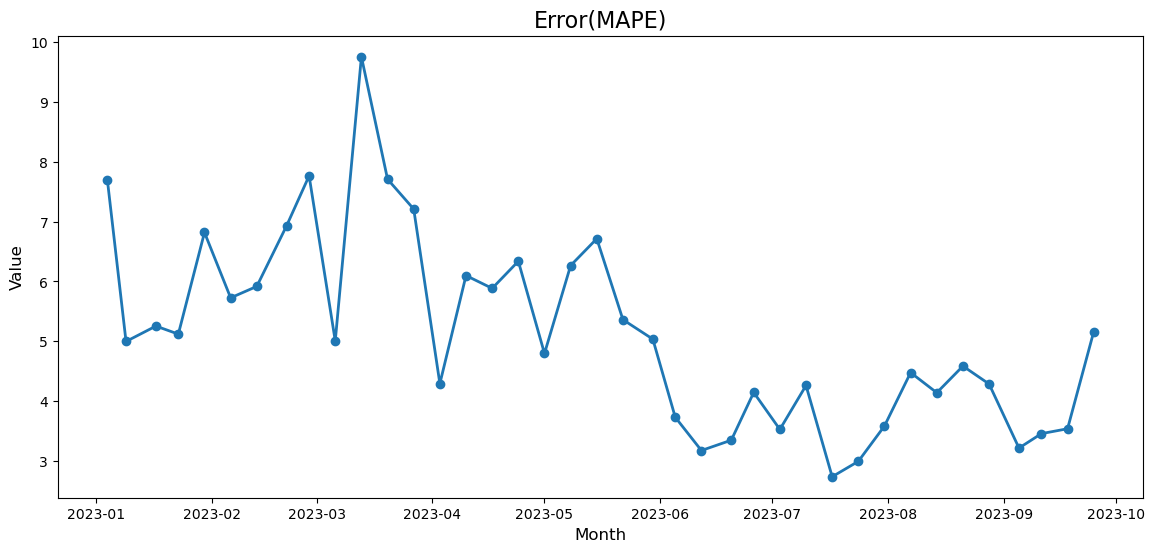

In [6]:

error = pd.DataFrame(list(errors_percent.items()), columns=['Date', 'Error']).sort_values(by = 'Date')
plt.figure(figsize=(14, 6))
plt.plot(error['Date'], error['Error'], marker='o', linestyle='-', linewidth=2)

plt.title('Error(MAPE)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Value', fontsize=12)

In [7]:
Heston_calibrated_parameters = pd.DataFrame(optmize_results,index=['v0', 'theta', 'kappa', 'sigma', 'rho']).T.sort_index()
Heston_calibrated_parameters

,v0,theta,kappa,sigma,rho
2023-01-04,0.214613,0.072123,0.175857,8.518853e-05,0.033848
2023-01-09,0.148507,0.319745,0.233436,1.000000e-10,0.039103
2023-01-17,0.174104,0.346238,0.346984,2.445759e-05,0.024044
2023-01-23,0.148101,0.696114,0.450299,1.000000e-10,0.030243
2023-01-30,0.245998,0.795254,0.197629,4.540043e-06,0.033437
2023-02-06,0.404332,0.004207,0.050199,1.000000e-10,0.026009
2023-02-13,0.206791,0.029380,0.109203,5.579325e-04,0.027184
2023-02-21,0.375475,0.006089,0.058064,3.632535e-03,0.031290
2023-02-27,0.199351,0.108468,0.207476,9.620556e-06,0.026011
2023-03-06,0.147201,0.916642,0.518805,1.000000e-10,0.032487


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

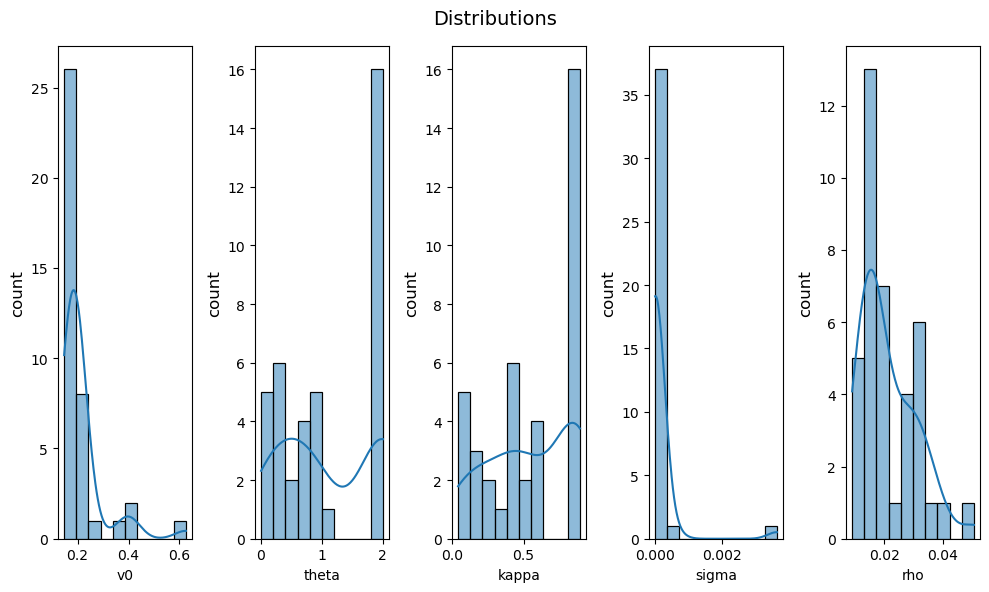

In [8]:
name = ['v0', 'theta', 'kappa', 'sigma', 'rho']

fig, axs = plt.subplots(1, 5, figsize=(10,6))


for i, param in enumerate(name):
    # 使用histplot可绘制柱状图+密度曲线,kde=True表示叠加核密度估计曲线
    sns.histplot(data=Heston_calibrated_parameters, x=param, kde=True, ax=axs[i], bins=10)
    axs[i].set_xlabel(param)
    axs[i].set_ylabel('count', fontsize=12)
fig.suptitle('Distributions', fontsize=14)
plt.tight_layout()
plt.show()

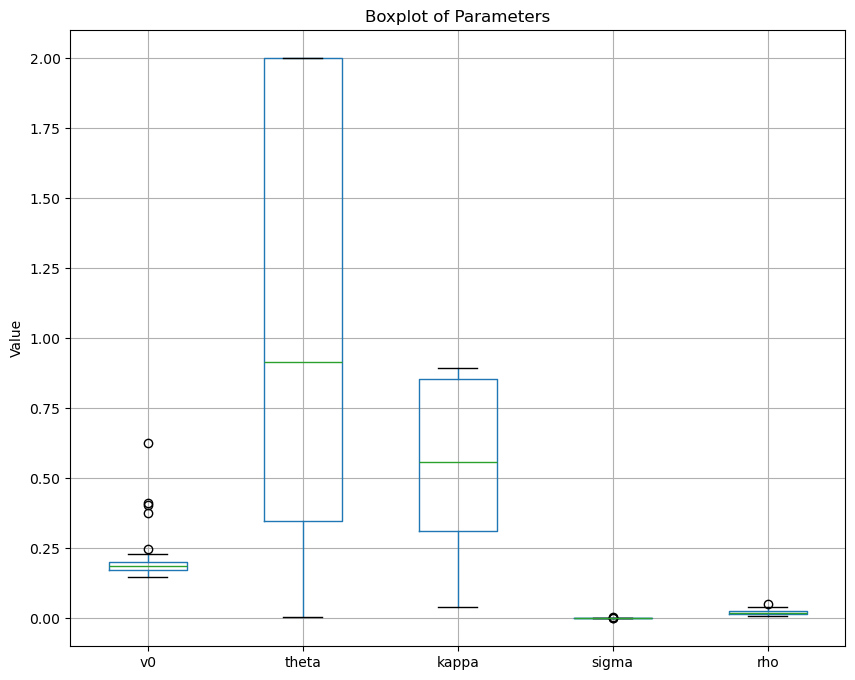

In [9]:
plt.figure(figsize=(10, 8))
Heston_calibrated_parameters.boxplot()
plt.title('Boxplot of Parameters')
plt.ylabel('Value')
plt.show()

In [10]:
Heston_calibrated_parameters.to_parquet('Heston_calibrated_parameters.pq')
Heston_calibrated_parameters.describe()

,v0,theta,kappa,sigma,rho
count,39.000000,39.000000,39.000000,3.900000e+01,39.000000
mean,0.213065,1.116336,0.550528,1.171474e-04,0.021235
std,0.090958,0.785947,0.301537,5.845658e-04,0.009533
min,0.147201,0.004207,0.041907,1.000000e-10,0.009006
25%,0.173841,0.348298,0.312742,1.000000e-10,0.014233
50%,0.187384,0.916642,0.557240,4.429184e-06,0.017916
75%,0.199458,1.999674,0.855108,1.834824e-05,0.027146
max,0.625159,2.000000,0.892851,3.632535e-03,0.050611
